<hr/>

# Data Mining [EN.550.436]
**Tamás Budavári** - budavari@jhu.edu <br/>
**Class 13** - Oct 20, 2016

- Exam 1
- Tree data structures
- Classification trees

<hr/>

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<h1><font color="darkblue">Exam 1</font></h1>

- Problem 1: fitting
- Problem 2: classification

### Problem 1

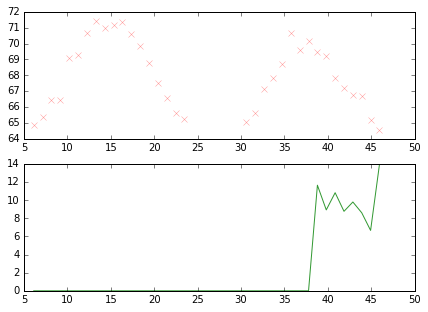

In [2]:
# read measurements
data = np.loadtxt('Exam1-Problem1.csv', delimiter=',')
hour, temp, rain = data[:,0], data[:,1], data[:,2]

# plot temp and rain as fn of hour
figure(figsize=(7,5))
subplot(211); plt.plot(hour,temp, 'rx', alpha=0.4); 
subplot(212); plt.plot(hour,rain, 'g-', alpha=0.8);

-2.1560257901953488

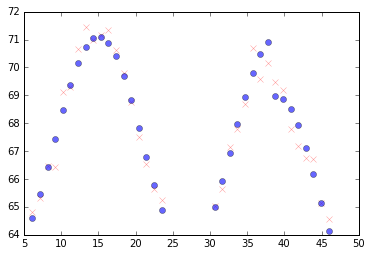

In [3]:
# analysis
X = np.zeros( (hour.size,4) );
X[:,0] = 1
X[:,1] = np.sin(hour * 2*pi/24)
X[:,2] = np.cos(hour * 2*pi/24)
#X[:,3] = rain # not so good with this model
indicator = np.array( (rain>0), dtype=np.float)
X[:,3] = indicator # better!!

Xpinv = np.linalg.inv( X.T.dot(X) ).dot(X.T)
coeff = Xpinv.dot(temp)
tpred = X.dot(coeff)

# plot temperatures for comparison
plt.plot(hour, temp, 'rx', alpha=0.4);
plt.plot(hour, tpred,'bo', alpha=0.6);

# print temperature drop during rain
coeff[-1]

### Problem 2

In [4]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

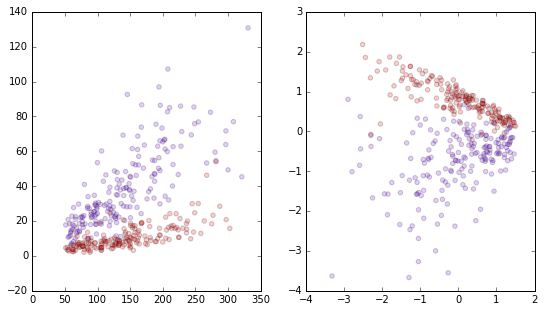

In [5]:
data = np.loadtxt('Exam1-Problem2.csv',delimiter=',')
X, Y = data[:,:2], data[:,2]
W = PCA(whiten=True).fit_transform(X)   #easy way of whitening

figure(figsize=(9,5))
subplot(121); plt.scatter(X[:,0],X[:,1],c=Y,cmap=cm.rainbow, alpha=0.2);
subplot(122); plt.scatter(W[:,0],W[:,1],c=Y,cmap=cm.rainbow, alpha=0.2);

In [6]:
classifiers = [ ('g',GaussianNB()), ('q',QDA()), ('l',LDA()), 
                ('k',KNeighborsClassifier(n_neighbors=15)) ]
split = 200

Xt, Xq = X[:split,:], X[split:,:]
Wt, Wq = W[:split,:], W[split:,:]
Yt, Yq = Y[:split], Y[split:]

for name, clf in classifiers:    
    nx = (Yq==clf.fit(Xt,Yt).predict(Xq)).sum() 
    nw = (Yq==clf.fit(Wt,Yt).predict(Wq)).sum()
    print name, float(nx)/(Y.size-split), float(nw)/(Y.size-split)   

g 0.807228915663 0.94578313253
q 0.94578313253 0.94578313253
l 0.921686746988 0.921686746988
k 0.921686746988 0.951807228916


<h1><font color="darkblue">Cross Validation</font></h1>

- Partition dataset into $k$ subsets, hold out one partition and train on the rest
- Previously implemented leave-one-out ($k=n$) and 2-fold cross-validation
- General implementation of $k$-fold cross-validation in sklearn

In [7]:
from sklearn import cross_validation    
cross_validation.cross_val_score(QDA(), X,Y, cv=10)

array([ 0.94594595,  0.91891892,  0.89189189,  0.97297297,  1.        ,
        0.91891892,  1.        ,  1.        ,  0.97222222,  0.91428571])

In [8]:
kfold = 10
for name, clf in classifiers:
    raw = cross_validation.cross_val_score(clf, X,Y, cv=kfold)
    wht = cross_validation.cross_val_score(clf, W,Y, cv=kfold)
    print name, '\t', raw.mean(), '\t', wht.mean()

g 	0.830909480909 	0.94262977263
q 	0.953515658516 	0.953515658516
l 	0.931439296439 	0.931439296439
k 	0.947805662806 	0.950662805663


<h1><font color="darkblue">Trees</font></h1>

- Recursive data structures

> **Recursion**<br/>
> "To know recursion, you must first know recursion." 

> **Recursive Acronyms** <br/>
>   GNU: GNU is Not Unix <br/>
>   LAME: LAME Ain't an MP3 Encoder<br/>
>   PIP: PIP Installs Packages

- Used everywhere

> Searches, decisions, etc...


In [13]:
# factorial using recursion: n!
def f(n):
    if n>0: return n * f(n-1)
    else: return 1

print f(0), f(1), f(2), f(3), f(4)
print map(f, range(5))

1 1 2 6 24
[1, 1, 2, 6, 24]


### Binary Tree
- Connected nodes - special tree structures

> There is one root node

> Every node has maximum two nodes (left, right)

> Leaves are the terminal nodes

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f7/Binary_tree.svg" alt="Binary tree.svg" height="250" width="300" align=left>

In [14]:
class node(object):
    
    def __init__(self,data,left=None,right=None):
        self.data = data
        self.left = left
        self.right = right
        
    def __repr__(self,i=0):
        s = '\t'*i + repr(self.data) + '\n'
        if self.left is not None:  
            s += self.left.__repr__(i+1)
        if self.right: # same thing
            s += self.right.__repr__(i+1)
        return s

root = node(2, 
            node(7,
                 node(2), 
                 node(6, node(5), node(11))),
            node(5, None,
                 node(9, node(4)))
           )

print root

2
	7
		2
		6
			5
			11
	5
		9
			4



In [15]:
print root.left.left.left
root.left.left.left = node(99)
print root

None
2
	7
		2
			99
		6
			5
			11
	5
		9
			4



In [16]:
print root.right.right.data

9


### $n$-ary Tree

In [17]:
class node(object):
    
    def __init__(self, data, children=[]):
        self.data = data
        self.children = children
        
    def __repr__(self, i=0):
        s = '\t'*i + repr(self.data) + '\n' 
        for child in self.children:
            s += child.__repr__(i+1)
        return s

In [18]:
# build a tree
root = node(2, [
            node(7, [
                node(2),
                node(6, [
                        node(5), 
                        node(11)])]),
            node(5, [
                node(9, [node(4)])])
            ]);

print root

2
	7
		2
		6
			5
			11
	5
		9
			4



### Trees are everywhere!

- Searching

> $k$d-trees, B-tree, R-tree, ball trees, etc...

> E.g., for nearest neighbor searches

- Decisions 

> E.g., for classification 

### $k$-d tree

- Balanced tree
- Split along axes

Constructed from points (Wikipedia)<br/>
{ (2,3), (5,4), (9,6), (4,7), (8,1), (7,2) }

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Kdtree_2d.svg/1200px-Kdtree_2d.svg.png" alt="Kdtree 2d.svg" width=350 align=left> 

##### <h1><font color="darkblue">Decision Tree</font></h1>

- Recursive partitioning of the training dataset

> At a given node with dataset $D$ we look for the
> best split 

> $\theta = $ (feature $j$, threshold $t$) 

> such that the 
> partitions $D_{\textrm{left}}(\theta)$ and $D_{\textrm{right}}(\theta)$ have minimal *impurity*

> $\displaystyle I(\theta) = \frac{n_{\textrm{left}}}{n}\, H\Big(D_{\textrm{left}}(\theta)\Big) + \frac{n_{\textrm{right}}}{n}\,H\Big(D_{\textrm{right}}(\theta)\Big)$

- Different impurity functions $H(\cdot)$

> E.g., Gini for classifying into $K$ classes

>$\displaystyle H(D) = \sum_{i=1}^K p_i (1-p_i)$

> Or variance for regression


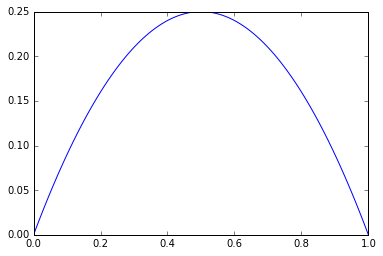

In [19]:
x = np.linspace(0,1,100)
plot(x, x*(1-x));

In [10]:
from sklearn import tree
X = [[0,0], [1,0], [1,1],[0.2,1]]
Y = [0, 1, 0,1]

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

print clf.predict([ [2,2], [0.1,0], [0.2,1], [1,0.3] ])

[0 0 1 1]


### Exercise #1

Use the sklearn routines to 

- Load the iris datasets
- Run the decisions tree
- Cross-Validation
- Plots results

<a href="http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html#sphx-glr-auto-examples-tree-plot-iris-py"><img src="http://scikit-learn.org/stable/_images/sphx_glr_plot_iris_0011.png" align=left width=500 \></a>

<h1><font color="darkblue">Random Forest</font></h1>

- Random Tree

> Hard to pick the *best* in high dimensions (i.e., very expensive)

> Instead we pick a number of random directions to search<br/>
> and take the optimal split among those

- Random Forest

> Create multiple random trees to classify <br/>
> and combine the results, e.g., voting



### Exercise #2

- Repeat exercise #1 using the random forest classifer

In [17]:
from sklearn.ensemble import RandomForestClassifier

### Comparison of Classifiers

 - Check out the 
<a href="http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html">demo script</a> running a bunch of classifiers in sklearn 